<a href="https://colab.research.google.com/github/hw-problem-org/cs294_158_2020/blob/master/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount the project in Google Colab

GUEST = False
COURSE = 'cs294_158_2020'
HOMEWORK = 'hw1'

import os
if GUEST:
  !git clone https://github.com/hw-problem-org/cs294_158_2020.git
else:
  # Mount Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  # Setup Symlink to project folder
  HW_PATH = '/content/gdrive/My\ Drive/' + COURSE + '/' + HOMEWORK
  DEEPUL_PATH = '/content/gdrive/My\ Drive/' + COURSE + '/deepul'
  SETUP_PATH = '/content/gdrive/My\ Drive/' + COURSE + 'setup.py'
  SYM_PATH = '/content/' + COURSE
  if not os.path.exists(SYM_PATH):
    !mkdir -p $SYM_PATH
    !ln -s $HW_PATH $SYM_PATH
    !ln -s $DEEPUL_PATH $SYM_PATH
    !ln -s $SETUP_PATH $SYM_PATH

# Change pwd to Homework directory
os.chdir( '/content/' + COURSE + '/' + HOMEWORK)

# Install deepul package
!pip install .. > /dev/null 2>&1

if GUEST:
  !unzip -qq data/hw1_data.zip -d data/
  !rm data/hw1_data.zip

Mounted at /content/gdrive


In [2]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


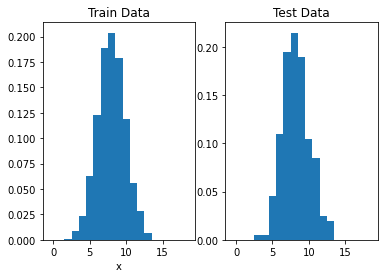

Dataset 2


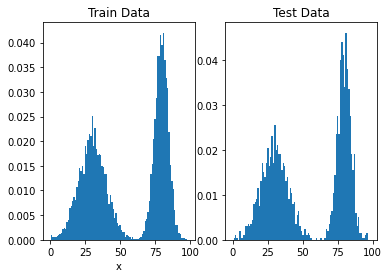

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [3]:
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

def train(model, train_loader, optimizer):
  model.train()
  train_losses = []
  for x in train_loader:
    x = x.cuda()
    optimizer.zero_grad()
    loss = model.loss(x)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def test(model, test_loader):
  model.eval()
  test_loss = torch.zeros(1).cuda()
  with torch.no_grad():
    for x in test_loader:
      x = x.long().cuda()
      test_loss += model.loss(x) * x.shape[0]
    avg_loss = test_loss / len(test_loader.dataset)
  return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
  lr = train_args['lr']
  epochs = train_args['epochs']
  optimizer = Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [test(model, test_loader)]
  for epoch in range(epochs):
    train_losses.extend(train(model, train_loader, optimizer))
    test_losses.append(test(model, test_loader))
  return train_losses, test_losses

class Histogram(nn.Module):
  def __init__(self, d):
    nn.Module.__init__(self)
    self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

  def loss(self, target):
    input = self.logits.unsqueeze(0).repeat(target.shape[0] , 1).cuda()
    return F.cross_entropy(input, target, reduction='mean')

  def get_distribution(self):
    return F.softmax(self.logits, dim=0).detach().cpu().numpy()

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, d: {d}, dset_id: {dset_id}")
  if dset_id == 1:
    batch_size = 100
  elif dset_id == 2:
    batch_size = 1000

  train_loader =  DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader =  DataLoader(train_data, batch_size=batch_size)
  model = Histogram(d)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {'lr': 0.1, 'epochs': 20})
  distribution = model.get_distribution()

  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



train_data: (800,), test_data: (200,), d: 20, dset_id: 1
Final Test Loss: 2.0695


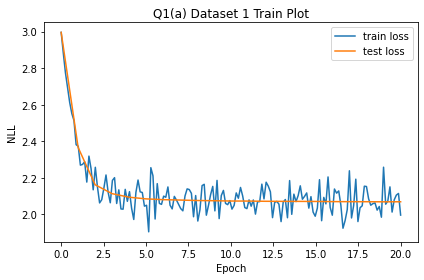

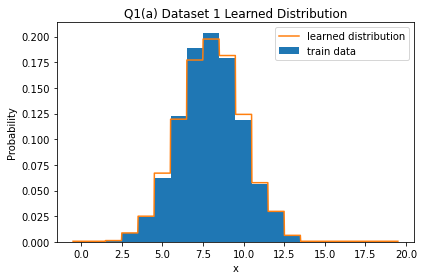

In [ ]:
q1_save_results(1, 'a', q1_a)

train_data: (8000,), test_data: (2000,), d: 100, dset_id: 2
Final Test Loss: 4.0392


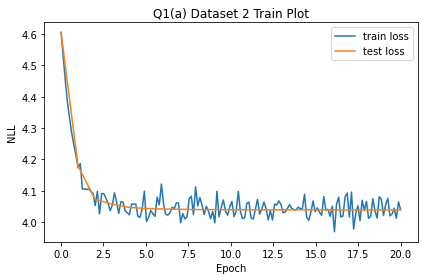

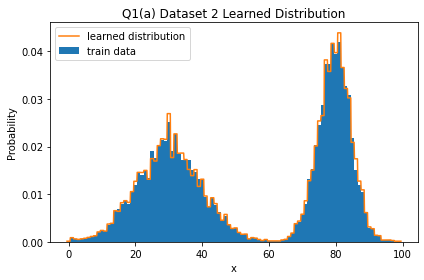

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class MixtureOfLogistics(nn.Module):
  def __init__(self, d, k=4):
    nn.Module.__init__(self)
    self.d = d # Data Domain size
    self.k = k # Number of mixture of Logistics

    self.pi_unnormalized = nn.Parameter(torch.ones(k, device='cuda', dtype=torch.float32), requires_grad=True)
    self.mu = nn.Parameter(torch.arange(k, device='cuda', dtype=torch.float32), requires_grad=True)
    self.logs = nn.Parameter(torch.randn(k, device='cuda', dtype=torch.float32), requires_grad=True)

  def forward(self, x):
    pi = F.softmax(self.pi_unnormalized, dim=0)
    
    x_unsqueeze = x.unsqueeze(0).repeat(self.k, 1)
    mu_unsqueeze  = self.mu.unsqueeze(1).repeat(1, x.shape[0])
    s = torch.exp(self.logs)
    s_unsqueeze  = s.unsqueeze(1).repeat(1, x.shape[0])

    x_unsqueeze_plus = x_unsqueeze + 0.5
    x_unsqueeze_minus = x_unsqueeze - 0.5

    x_plus = (x_unsqueeze_plus - mu_unsqueeze) / s_unsqueeze
    x_minus = (x_unsqueeze_minus - mu_unsqueeze) / s_unsqueeze

    cdf_plus = torch.sigmoid(x_plus)
    cdf_plus = torch.where(x_unsqueeze_plus >= self.d - 1, torch.tensor([1], dtype=torch.float32, device='cuda'), cdf_plus)
    cdf_minus = torch.sigmoid(x_minus)
    cdf_minus = torch.where(x_unsqueeze_minus <= 0, torch.tensor([0], dtype=torch.float32, device='cuda'), cdf_minus)
    cdf_delta = torch.clamp(cdf_plus - cdf_minus, min=1e-12) # For Numerical Stability

    return torch.mm( pi.unsqueeze(0), cdf_delta).squeeze()

  def loss(self, x):
    loss = torch.mean( -torch.log( self(x) ) )
    return loss

  def get_distribution(self):
    with torch.no_grad():
      distribution = self(torch.arange(self.d, device='cuda'))
      return distribution.detach().cpu().numpy()
    

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, d: {d}, dset_id: {dset_id}")
  if dset_id == 1:
    batch_size = 100
  elif dset_id == 2:
    batch_size = 200

  model = MixtureOfLogistics(d, k=5)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=50, lr=1e-1))
  distribution = model.get_distribution()

  return train_losses, test_losses, distribution


### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



train_data: (800,), test_data: (200,), d: 20, dset_id: 1
Final Test Loss: 2.0758


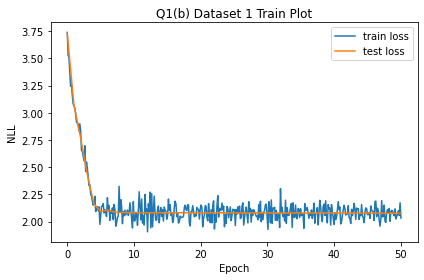

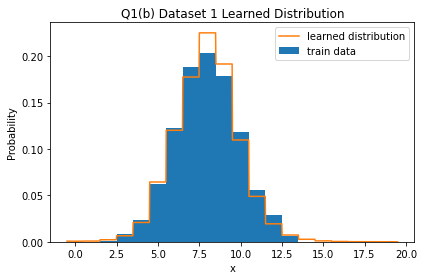

In [ ]:
q1_save_results(1, 'b', q1_b)

train_data: (8000,), test_data: (2000,), d: 100, dset_id: 2
Final Test Loss: 4.0534


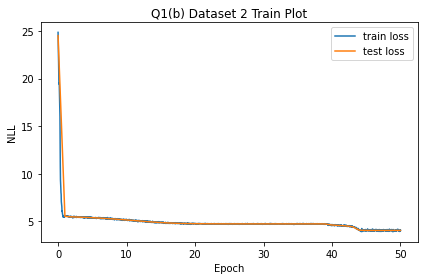

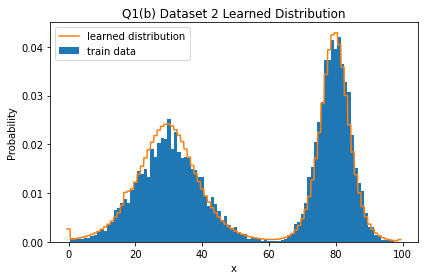

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


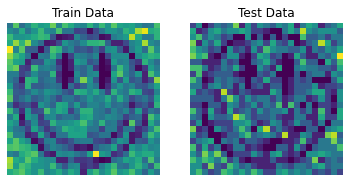

Dataset 2


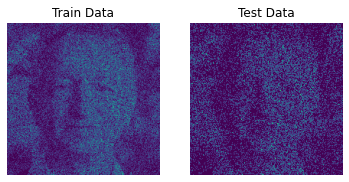

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

def to_one_hot(labels, d):
  one_hot = torch.FloatTensor(labels.shape[0], d).cuda()
  one_hot.zero_()
  one_hot.scatter_(1, labels.unsqueeze(1), 1)
  return one_hot

class MaskedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
    super().__init__(in_features, out_features, bias=bias, device=device, dtype=dtype)
    self.register_buffer('mask', torch.ones((out_features, in_features), dtype=torch.uint8))

  def set_mask(self, mask):
    self.mask.data.copy_( torch.as_tensor(mask.astype(np.uint8).T) )

  def forward(self, input):
    return F.linear(input, self.weight * self.mask, self.bias)

class MADE(nn.Module):
  def __init__(self, input_shape, d, hidden_sizes, one_hot_input=False, ordering=None):
    super().__init__()
    self.input_shape = input_shape
    self.nin = np.prod(input_shape)

    self.d = d
    self.nout = self.nin * d

    self.hidden_sizes = hidden_sizes

    self.one_hot_input = one_hot_input

    self.ordering = np.arange(self.nin) if ordering is None else ordering

    ## Define a simple MLP Neural Net
    self.net = []
    hs = [self.nin * d if one_hot_input else self.nin] + hidden_sizes + [self.nout]
    for h0, h1 in zip(hs, hs[1:]):
      self.net.extend([MaskedLinear(h0, h1), nn.ReLU()])
    self.net.pop() # pop the last ReLU for the output layer
    self.net = nn.Sequential(*self.net)

    ## Masks for MaskedLinear layers
    self.m = {}
    self.create_mask()

  def create_mask(self):
    L = len(self.hidden_sizes)

    # sample the order of the inputs and the connectivity of all neurons
    self.m[-1] = self.ordering
    for l in range(L):
      self.m[l] = np.random.randint(self.m[l-1].min(), self.nin - 1, self.hidden_sizes[l])

    # construct the mask matrices
    masks = [self.m[l-1][:,None] <= self.m[l][None, :] for l in range(L)]
    masks.append(self.m[L-1][:, None] < self.m[-1][None, :])
    if self.one_hot_input:
      masks[0] = np.repeat(masks[0], self.d, axis=0)
    masks[-1] = np.repeat(masks[-1], self.d, axis=1)

    # set the masks in all MaskedLinear layers
    masked_layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
    for masked_layer, mask in zip(masked_layers, masks):
      masked_layer.set_mask(mask)

  def forward(self, x):
    batch_size = x.shape[0]
    if self.one_hot_input:
      x = x.long().view(-1)
      x = to_one_hot(x, self.d)
      x = x.view(batch_size, -1)
    else:
      x = x.view(batch_size, self.nin).to(torch.float32)
    logits = self.net(x).view(batch_size, self.nin, self.d)
    return logits

  def loss(self, x):
    input = self(x).view(-1,self.d)
    target = x.long().view(-1)
    return F.cross_entropy(input, target)

  def sample(self, n):
    with torch.no_grad():
      samples = torch.zeros(n, self.nin).cuda()
      for i in range(self.nin):
        log_probs = F.log_softmax(self(samples), dim=-1)
        samples[:,i] = torch.multinomial(log_probs[:,i,:].exp(), 1).squeeze()
      samples = samples.view(n, *self.input_shape)
    return samples.cpu().numpy()

  def get_distribution(self):
    with torch.no_grad():
      x = np.swapaxes( np.mgrid[0:self.d, 0:self.d], 1, 2 ).T.reshape(self.d ** 2, 2)
      x = torch.as_tensor(x).contiguous().cuda()
      log_probs = F.log_softmax(self(x), dim=-1)
      log_prob = torch.gather(log_probs.view(-1, self.d), -1, x.view(-1).unsqueeze(1)).view(self.d * self.d, 2)
      distribution = torch.prod(log_prob.exp(), axis=-1).view(self.d, self.d)
      return distribution.detach().cpu().numpy()

In [ ]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, d: {d}, dset_id: {dset_id}")
  if dset_id == 1:
    batch_size = 400
    lr = 2e-3
  elif dset_id == 2:
    batch_size = 800
    lr = 5e-4
  
  hidden_size=[256, 256]
  model = MADE(train_data.shape[1:], d, hidden_size, one_hot_input=True).cuda()
  train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=batch_size)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {"epochs": 10, "lr": lr})
  distribution = model.get_distribution()

  # distribution = np.zeros((d,d))
  # distribution[0,0] = 1

  return train_losses, test_losses, distribution

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



train_data: (8000, 2), test_data: (2000, 2), d: 25, dset_id: 1
Final Test Loss: 3.1848


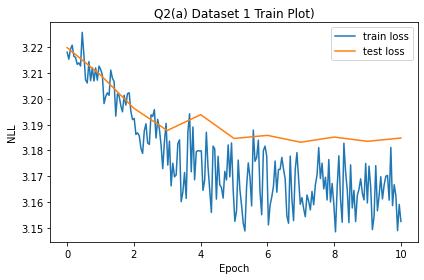

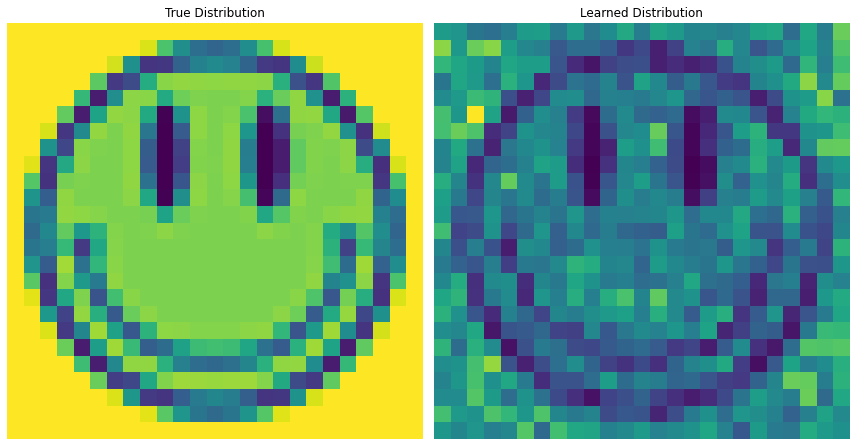

In [ ]:
q2_save_results(1, 'a', q2_a)

train_data: (80000, 2), test_data: (20000, 2), d: 200, dset_id: 2
Final Test Loss: 5.2733


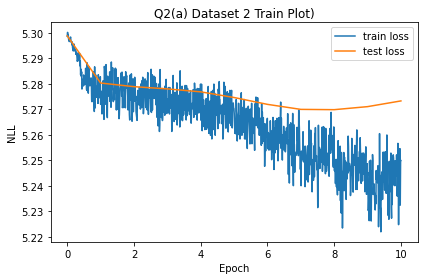

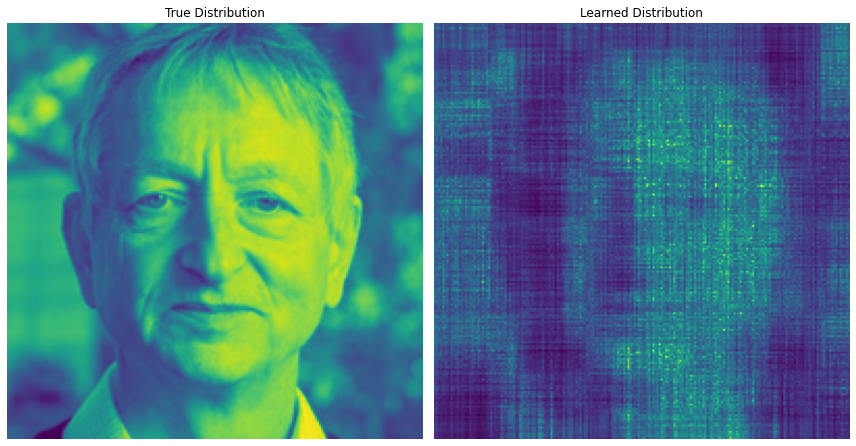

In [ ]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

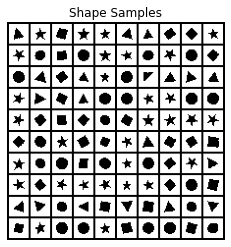

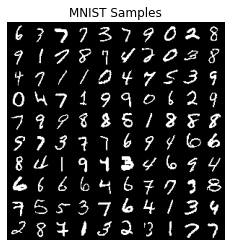

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, image_shape: {image_shape}, dset_id: {dset_id}")

  hidden_size=[512, 512, 512]
  model = MADE(train_data.shape[1:], 2, hidden_size, one_hot_input=True).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {"epochs": 40, "lr": 1e-3})

  samples = model.sample(100)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



train_data: (10479, 20, 20, 1), test_data: (4491, 20, 20, 1), image_shape: (20, 20), dset_id: 1
Final Test Loss: 0.0555


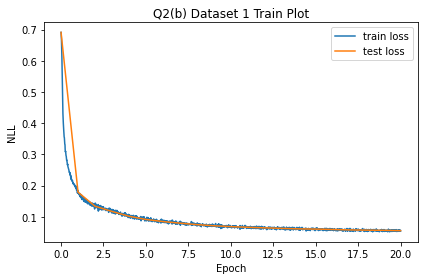

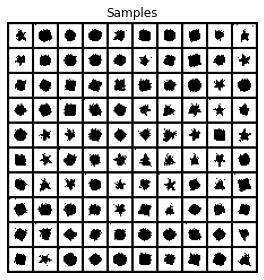

In [ ]:
q2_save_results(1, 'b', q2_b)

train_data: (60000, 28, 28, 1), test_data: (10000, 28, 28, 1), image_shape: (28, 28), dset_id: 2
Final Test Loss: 0.1247


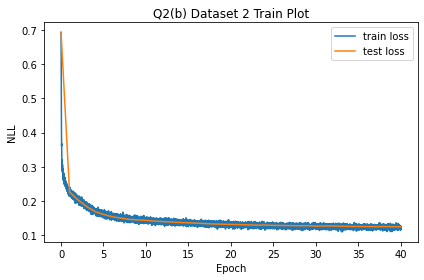

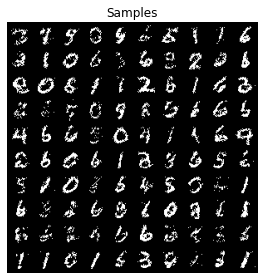

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch

class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
    assert mask_type == 'A' or mask_type == 'B'
    super().__init__(in_channels, out_channels, kernel_size, padding=padding)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:, :, :k // 2] = 1
    self.mask[:, :, k // 2, :k // 2] = 1
    if mask_type == 'B':
      self.mask[:, :, k // 2, k // 2] = 1

  def forward(self, input, cond=None):
    batch_size = input.shape[0]
    out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    return out

class ResBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.block = nn.Sequential(
        nn.ReLU(),
        MaskConv2d('B', in_channels, in_channels//2, 1),
        nn.ReLU(),
        MaskConv2d('B', in_channels//2, in_channels//2, 7, padding=7//2),
        nn.ReLU(),
        MaskConv2d('B', in_channels// 2, in_channels, 1)
    )

  def forward(self, x):
    return self.block(x) + x

class LayerNorm(nn.LayerNorm):
  def __init__(self, n_filters):
    super().__init__(n_filters)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()

class PixelCNN(nn.Module):
  def __init__(self, input_shape, n_colors, n_filters=64, kernel_size=7, n_layers=5, use_resblock=False) :
    super().__init__()
    assert n_layers >= 2
    n_channels = input_shape[0]
    
    self.input_shape = input_shape
    self.n_colors = n_colors
    self.n_channels = n_channels

    module_list = [MaskConv2d('A', n_channels, n_filters, kernel_size, padding=kernel_size // 2)]

    if use_resblock:
      block_init = lambda: ResBlock(n_filters)
    else:    
      block_init = lambda: MaskConv2d('B', n_filters, n_filters, kernel_size, padding=kernel_size // 2)

    for _ in range(n_layers):
      module_list.append(LayerNorm(n_filters))
      module_list.extend([nn.ReLU(), block_init()])

    module_list.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1)])
    module_list.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_channels * n_colors, 1)])

    self.net = nn.Sequential(*module_list)

  def forward(self, x):
    batch_size = x.shape[0]
    return self.net(x.float()).view(batch_size, self.n_colors, *self.input_shape)

  def loss(self, x):
    return F.cross_entropy(self(x), x.long())

  def sample(self, n):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for h in range(self.input_shape[1]):
        for w in range(self.input_shape[2]):
          for c in range(self.n_channels):
            logits = self(samples)[:, :, c, h, w]
            probs = F.softmax(logits, dim=1)
            samples[:, c, h, w] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, image_shape: {image_shape}, dset_id: {dset_id}")

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W = image_shape
  model = PixelCNN((1, H, W), 2, n_layers=5).cuda()

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {'epochs': 10, 'lr': 1e-3})
  samples = model.sample(100)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



train_data: (10479, 20, 20, 1), test_data: (4491, 20, 20, 1), image_shape: (20, 20), dset_id: 1
Final Test Loss: 0.0637


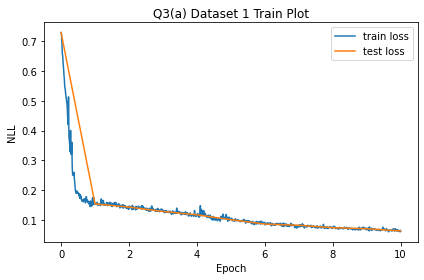

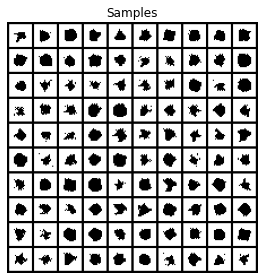

In [ ]:
q3a_save_results(1, q3_a)

train_data: (60000, 28, 28, 1), test_data: (10000, 28, 28, 1), image_shape: (28, 28), dset_id: 2
Final Test Loss: 0.0789


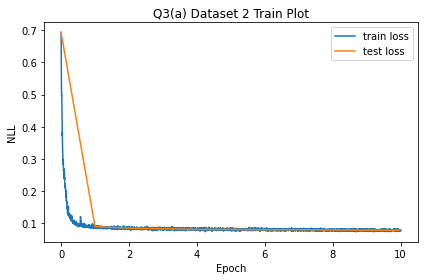

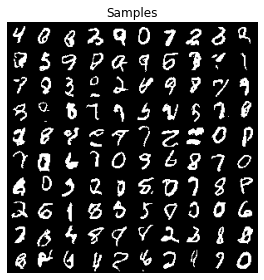

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

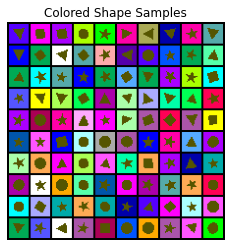

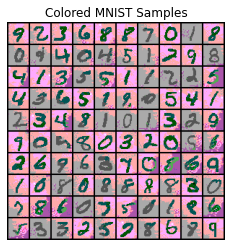

In [6]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [20]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, image_shape: {image_shape}, dset_id: {dset_id}")

  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W, C = image_shape
  model = PixelCNN((C, H, W), 4, n_layers=8, n_filters=120, use_resblock=True).cuda()

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {'epochs': 15, 'lr': 1e-3})
  samples = model.sample(100)
  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



train_data: (10479, 20, 20, 3), test_data: (4491, 20, 20, 3), image_shape: (20, 20, 3), dset_id: 1
Final Test Loss: 0.0513


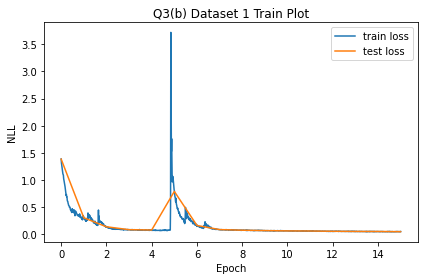

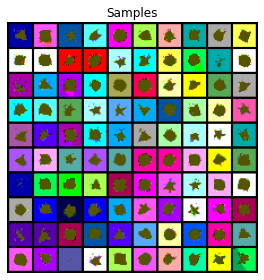

In [21]:
q3bc_save_results(1, 'b', q3_b)

train_data: (60000, 28, 28, 3), test_data: (10000, 28, 28, 3), image_shape: (28, 28, 3), dset_id: 2
Final Test Loss: 0.2684


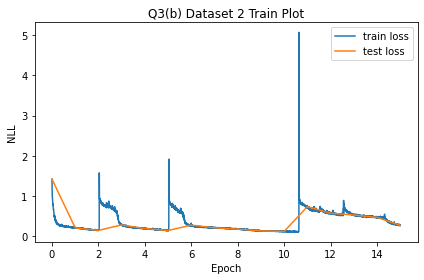

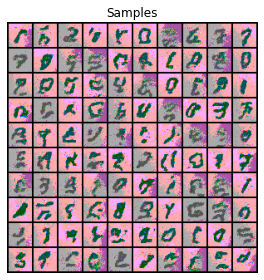

In [22]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """
  pass

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Final Test Loss: 0.0236


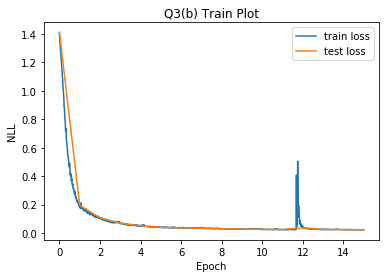

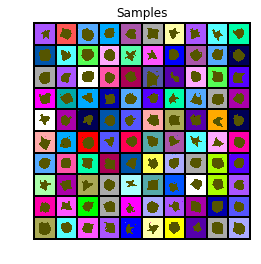

In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Final Test Loss: 0.0368


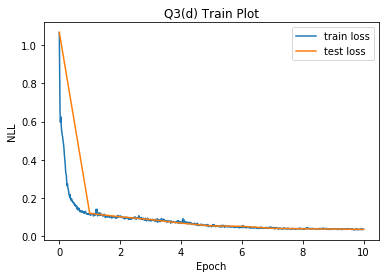

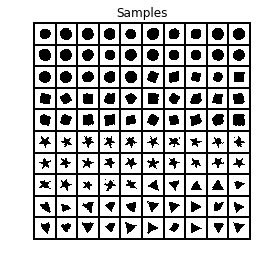

In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)